In [1]:
close all
clear all
graphics_toolkit ("gnuplot");


The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are unlikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update its internal list of open figure windows.
The qt toolkit is recommended instead.



In [2]:
%THE WHOLE PURPOSE OF THIS CODE IS TO GENERATE THE NECESSARY DATA TO READ
%INTO THE MACROSCALE MODEL - THE 4 FILES THAT WE SAVE USING THE "save"
%COMMAND IN THIS CODE. WE ALSO GENERATE SOME INFORMATION ABOUT THE
%MICROSCALE MODEL RESULTS, LIKE THE MEDIAN TPA LEAVING TIMES AND LYSIS
%TIMES

binaryformat='ieee-le';

expCode = '2024-01-31-1501';
fileCode = '_PLG2_tPA01_Q0.dat';
runs=50000;%10000;

In [3]:
folder = strcat('../../data/', expCode);
%FOR 'BINARY' DATA. READ IN THE FILES GENERATED WITH FORTRAN
fids(1) = fopen(strcat(folder, '/lysis', fileCode),'r',binaryformat);
fids(2) = fopen(strcat(folder, '/tPA_time', fileCode),'r',binaryformat);
fids(3) = fopen(strcat(folder, '/PLi', fileCode),'r',binaryformat);
fids(4) = fopen(strcat(folder, '/lyscomplete', fileCode),'r',binaryformat);
fids(5) = fopen(strcat(folder, '/firstPLi', fileCode),'r',binaryformat);
fids(12) = fopen(strcat(folder, '/lasttPA', fileCode),'r',binaryformat);

%RENAME NEW FILES SOMETHING SHORTER 
lysis = fread(fids(1),inf,'double');
tPA = fread(fids(2),inf,'double');
PLi = fread(fids(3),inf,'int');
lyscom=fread(fids(4),inf,'int');
firstPLi=fread(fids(5),inf,'double');
lasttPA=fread(fids(12),inf,'int');

%CLOSE THE FILES SO YOU DON'T ACCIDENTALLY RE-READ THE DATA 
fclose(fids(1));
fclose(fids(2));
fclose(fids(3));
fclose(fids(4));
fclose(fids(5));
fclose(fids(12));

In [4]:
%READ IN ADDITIONAL FILES GENERATED WITH FORTRAN
fids(5) = fopen(strcat(folder, '/tPAPLiunbd', fileCode),'r',binaryformat);
fids(6) = fopen(strcat(folder, '/tPAunbind', fileCode),'r',binaryformat);


%RENAME THOSE FILES
tPAforced = fread(fids(5),inf,'int');
tPAunbound = fread(fids(6),inf,'int');

%FIND THE NUMBER OF TIMES TPA WAS FORCED TO UNBIND BY PLASMIN-MEDIATED
%DEGRADATION OF FIBRIN (num_forced) AND THE NUMBER OF TIMES TPA UNBOUND ON
%ITS OWN (num_unbd)
num_forced=length(find(tPAforced==1))
num_unbd=length(find(tPAunbound==1))
frac_forced = num_forced / (num_forced + num_unbd)

%CLOSE THE FILES
fclose(fids(5));
fclose(fids(6));

num_forced = 4647
num_unbd = 44078
frac_forced = 0.095372


In [5]:
%FIND THE NUMBER OF RUNS FOR WHICH TPA STAYED BOUND THE WHOLE SIMULATION
tPAstay=length(find(lasttPA==1)); 


%RENAME THE FILES SO WE CAN MANIPULATE THEM WITHOUT AFFECTING THE ORIGINAL
%DATA
tPAn=tPA;
PLin=PLi;
lysisn=lysis;
asd1=find(lyscom==0);
num_runs_lysis_complete=runs-length(asd1)

%SET THE lysisn ENTRIES FOR WHICH LYSIS DID NOT OCCUR (lyscomplete=0) EQUAL
%TO 100*60 SECONDS
for i=1:length(asd1)
    lysisn(asd1(i))=100*60;
end

%SORT THE tPAn VECTOR SO THAT ITS ENTRIES ARE IN ASCENDING ORDER. REARRANGE 
%THE PLin AND lysisn VECTORS SO THAT EACH ENTRY STILL CORRESPONDS TO ITS
%APPROPRIATE tPAn ENTRY. E.G., THE FIRST ENTRIES IN tPAn, PLin, and lysisn, 
%ALL CORRESPOND TO THE OUTPUT FROM THE FIRST RUN OF THE MICROSCALE MODEL
%(RECALL WE DID 10,000 RUNS). IF WE REARRANGE tPAn (BY MAKING THE NEW
%VECTOR StPA), AND WHAT USED TO BE THE FIRST ENTRY IS NOW THE 108TH ENTRY,
%WE NEED TO MOVE THE FIRST ENTRIES OF PLin AND lysisn TO THE 108TH ENTRIES
%OF THEIR NEW VECTORS, SPLi AND Slysis.
[StPA,IX]=sort(tPAn);
for i=1:length(IX)
    SPLi(i)=PLin(IX(i));
    Slysis(i)=lysisn(IX(i));
end
%SO NOW StPA IS A VECTOR OF TPA LEAVING TIMES IN ASCENDING ORDER. SPLi AND
%Slysis ARE NOT IN ASCENDING ORDER. 

num_runs_lysis_complete = 6376


In [6]:
if runs==50000
%BECAUSE I DID 50,000 RUNS, IF I BIN EVERY 500 TPA LEAVING TIMES, I'LL HAVE 
%BINNED BY 1% OF THE TOTAL NUMBER OF RUNS. CREATE MATRICES StPAmat AND 
%Slysismat TO HOLD THE DATA FOR EACH BIN. COLUMN=BIN NUMBER, AND THE ROW 
%ENTRIES ARE THE DATA FOR BIN GIVEN BY COLUMN NUMBER
    StPAmat=zeros(500,100);
    Slysismat=zeros(500,100);
    for i=1:100
        StPAmat(:,i)=StPA((i-1)*500+1:i*500);
        Slysismat(:,i)=Slysis((i-1)*500+1:i*500);
        tPAbin(i)=StPA(i*500);    %SAVES THE ACTUAL TIMES THE BINS ARE BROKEN UP INTO
    end

elseif runs==10000
%BECAUSE I DID 10,000 RUNS, IF I BIN EVERY 100 TPA LEAVING TIMES, I'LL HAVE 
%BINNED BY 1% OF THE TOTAL NUMBER OF RUNS. CREATE MATRICES StPAmat AND 
%Slysismat TO HOLD THE DATA FOR EACH BIN. COLUMN=BIN NUMBER, AND THE ROW 
%ENTRIES ARE THE DATA FOR BIN GIVEN BY COLUMN NUMBER
    StPAmat=zeros(100,100);
    Slysismat=zeros(100,100);
    for i=1:100
        StPAmat(:,i)=StPA((i-1)*100+1:i*100);
        Slysismat(:,i)=Slysis((i-1)*100+1:i*100);
        tPAbin(i)=StPA(i*100);    %SAVES THE ACTUAL TIMES THE BINS ARE BROKEN UP INTO
    end
end

In [7]:
%INITIALIZE THE CDFbin VECTOR TO BE A VECTOR WITH 101 ENTRIES. THEN DEFINE
%THE VECTOR TO COUNT FROM 0 TO 1 BY STEPS OF 0.01. ADD AN ENTRY CONTAINING
%THE NUBMER 0 TO THE VECTOR tPAbin AND RENAME IT tPAbin2.
CDFbin=zeros(1,101);
CDFbin=[0:0.01:1];
tPAbin2=horzcat(0,tPAbin);


%FIND THE TRANSPOSE OF THE tPAbin2 AND CDFbin VECTORS AND RENAME THEM
tsectPA=tPAbin2';
tPAleave=CDFbin';

%SAVE THE ABOVE TWO VECTORS SO WE CAN READ THEM INTO THE MACROSCALE MODEL
save(strcat(folder, '/tsectPA', fileCode), 'tsectPA', '-ascii', '-double');
save(strcat(folder, '/tPAleave', fileCode), 'tPAleave', '-ascii', '-double');

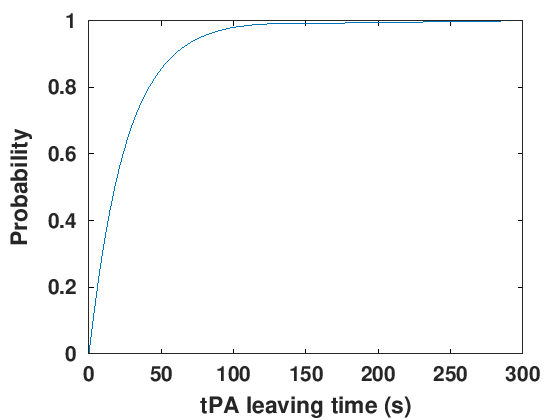

In [8]:
%MAKE A PLOT OF THE TPA LEAVING TIME CUMULATIVE DISTRIBUTION FUNCTION (CDF)
figure
plot(tsectPA,tPAleave,'LineWidth',3)
set(gca,'FontSize',16,'FontWeight','bold')
xlabel('tPA leaving time (s)','FontSize',16,'FontWeight','bold')
ylabel('Probability','FontSize',16,'FontWeight','bold')

In [9]:
%SORT THE ORIGINIAL PLin VECTOR SO THAT THE ENTRIES ARE IN ASCENDING ORDER.
%REORDER THE tPAn AND lysisn VECTORS SO THAT THE CORRESPONDING ENTRIES ARE
%IN THE CORRECT PLACES (LIKE WE DID WHEN WE SORTED THE tPAn VECTOR)
[SPLi3,IX3]=sort(PLin);
for i= 1:length(IX3)
    StPA3(i)=tPAn(IX3(i));
    Slysis3(i)=lysisn(IX3(i));
end

In [10]:
%MAKE NEW VECTORS Slysis3_0, Slysis3_1, Slysis3_2, Slysis3_3, Slysis3_4,
%Slysis3_5, WHICH CONTAIN THE LYSIS TIME DATA FOR WHICH 0 PLI, 1 PLI, 2 
%PLI, 3 PLI, 4 PLI, AND 5 OR MORE PLI WERE CREATED, RESPECTIVELY. SIMILARLY
%FOR THE TPA LEAVING TIME DATA.
end0=find(SPLi3==0,1,'last');
end1=find(SPLi3==1,1,'last');
end2=find(SPLi3==2,1,'last');
end3=find(SPLi3==3,1,'last');
end4=find(SPLi3==4,1,'last');
end5=find(SPLi3>=5,1,'last');
first1=find(SPLi3==1,1,'first');
first2=find(SPLi3==2,1,'first');
first3=find(SPLi3==3,1,'first');
first4=find(SPLi3==4,1,'first');
first5=find(SPLi3>=5,1,'first');

SPLi3_0=SPLi3(1:end0);
StPA3_0=StPA3(1:end0);
Slysis3_0=Slysis3(1:end0);
SPLi3_1=SPLi3(first1:end1);
StPA3_1=StPA3(first1:end1);
Slysis3_1=Slysis3(first1:end1);
SPLi3_2=SPLi3(first2:end2);
StPA3_2=StPA3(first2:end2);
Slysis3_2=Slysis3(first2:end2);
SPLi3_3=SPLi3(first3:end3);
StPA3_3=StPA3(first3:end3);
Slysis3_3=Slysis3(first3:end3);
SPLi3_4=SPLi3(first4:end4);
StPA3_4=StPA3(first4:end4);
Slysis3_4=Slysis3(first4:end4);
SPLi3_5=SPLi3(first5:end5);
StPA3_5=StPA3(first5:end5);
Slysis3_5=Slysis3(first5:end5);

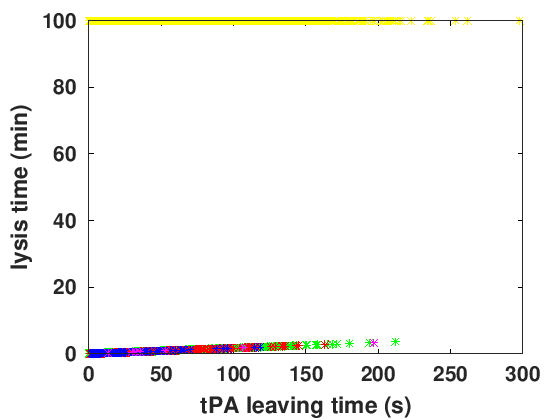

In [11]:
%MAKE A SCATTER PLOT OF TPA LEAVING TIME VS. LYSIS TIME, COLOR CODED BY THE
%NUMBER OF PLI MOLECULES CREATED IN EACH RUN
figure
plot(StPA3_0,Slysis3_0/60,'y*','MarkerSize',7)
hold on
plot(StPA3_1,Slysis3_1/60,'g*','MarkerSize',7)
plot(StPA3_2,Slysis3_2/60,'r*','MarkerSize',7)
plot(StPA3_3,Slysis3_3/60,'b*','MarkerSize',7)
plot(StPA3_4,Slysis3_4/60,'m*','MarkerSize',7)
plot(StPA3_5,Slysis3_5/60,'k*','MarkerSize',7)
set(gca,'FontSize',16,'FontWeight','bold')
xlabel('tPA leaving time (s)','FontSize',16,'FontWeight','bold')
ylabel('lysis time (min)','FontSize',16,'FontWeight','bold')

In [12]:
if runs==10000
    %FIND THE MEDIAN, FIRST QUARTILE, AND THIRD QUARTILE OF THE StPA DATA. THIS
    %GIVES THE MEDIAN, Q1, Q3 TPA LEAVING TIMES (IN S) FOR THE 10,000 RUNS
    mediantPA=median(StPA)
    Q1tPA=StPA(2500)
    Q3tPA=StPA(7501)
    %I USED THE MENDENHALL AND SINCICH METHOD FOR CALCULATING QUARTILES
elseif runs==50000
    %FIND THE MEDIAN, FIRST QUARTILE, AND THIRD QUARTILE OF THE StPA DATA. THIS
    %GIVES THE MEDIAN, Q1, Q3 TPA LEAVING TIMES (IN S) FOR THE 50,000 RUNS
    mediantPA=median(StPA)
    Q1tPA=StPA(12500)
    Q3tPA=StPA(37501)
    %I USED THE MENDENHALL AND SINCICH METHOD FOR CALCULATING QUARTILES
end

mediantPA = 17.925
Q1tPA = 7.5285
Q3tPA = 35.759


In [13]:
%SORT THE ORIGINIAL lysisn VECTOR SO ITS ENTRIES ARE IN ASCENDING ORDER.
%REORDER THE tPAn VECTOR SO THE CORRESPONDING ENTRIES ARE IN THE CORRECT
%PLACE. SIMILARLY FOR THE firstPLi VECTOR.
[T,IXL]=sort(lysisn);
for i=1:length(IXL)
    StPA2(i)=tPAn(IXL(i));
    fPLi(i)=firstPLi(IXL(i));
    nPLi(i)=PLin(IXL(i));
end
Tmin=T/60; %Tmin IS THE TIME DATA IN TERMS OF MINUTES INSTEAD OF SECONDS

In [14]:
%MAKE A VECTOR OF LYSIS TIMES FOR WHICH LYSIS ACTUALLY OCCURRED, AND VECTOR
%OF TIME TO FIRST PLASMIN MOLECULE IN RUNS WHERE LYSIS OCCURRED.
%***IN RUNS WITH alpha2-AP I'LL HAVE TO CHANGE THIS TO GIVE TIME TO FIRST
%PLASMIN IN RUN IN WHICH PLASMIN WAS CREATED

LT=Tmin(1:end-length(asd1));
LfPLi=fPLi(1:end-length(asd1));
LnPLi=nPLi(1:end-length(asd1));

In [15]:
%THIS IS PREP WORK IN ORDER TO ACCURATELY FIND THE MEDIAN, Q1, Q3 LYSIS
%TIMES
Lq=1/4*(length(LT)+1);
if abs(floor(Lq)-Lq)>=0.5
    Lq=floor(Lq)+1;
else
    Lq=floor(Lq);
end
Uq=3/4*(length(LT)+1);
if abs(floor(Uq)-Uq)>=0.5
    Uq=floor(Uq)+1;
else
    Uq=floor(Uq);
end

In [16]:
%FIND THE MEDIAN, FIRST QUARTILE, AND THIRD QUARTILE OF THE LT DATA. THIS
%GIVES THE MEDIAN, Q1, Q3 LYSIS TIMES (IN MIN) FOR THE 10,000 RUNS
medianlysis=median(LT)
Q1lysis=LT(Lq)
Q3lysis=LT(Uq)

%FIND THE MEDIAN, Q1 AND Q3 OF THE TIME TO PRODUCTION OF FIRST PLASMIN
%MOLECULE. THIS IS ONLY FOR RUNS IN WHICH PLASMIN WAS PRODUCED.
[mPLi,index_mPLi]=sort(LfPLi);
mediantimetoplasmin=median(mPLi)
Q1timetoplasmin=mPLi(Lq)
Q3timetoplasmin=mPLi(Uq)

medianlysis = 0.3621
Q1lysis = 0.2007
Q3lysis = 0.6486
mediantimetoplasmin = 16.851
Q1timetoplasmin = 7.1348
Q3timetoplasmin = 33.890


In [17]:
%FIND THE MAX NUMBER OF PLASMIN PRODUCED IN ANY RUN, AND THE MEDIAN, Q1 AND
%Q3 OF PLASMIN PRODUCED IN A GIVEN RUN. ***SHOULD THIS BE FOR ALL 10,000
%RUNS, OR JUST THOSE THAT RESULT IN DEGRADATION? FOR NOW, HAVE IT BE JUST
%FOR THOSE RESULTING IN DEGRADATION
maxPLi=max(PLi)
[mnPLi,index_mnPLi]=sort(LnPLi);
medianPLinum=median(mnPLi)
Q1PLinum=mnPLi(Lq)
Q3PLinum=mnPLi(Uq)

if runs==10000
    %IF I WANT MEDIAN OF ALL 10,000 RUNS, UNCOMMENT BELOW
    [mnPLi2,index_mnPLi2]=sort(PLin);
    medianPLinum2=median(mnPLi2)
    Q1PLinum2=mnPLi2(2500)
    Q3PLinum2=mnPLi2(7501)

elseif runs==50000
    %IF I WANT MEDIAN OF ALL 50,000 RUNS, UNCOMMENT BELOW
    [mnPLi2,index_mnPLi2]=sort(PLin);
    medianPLinum2=median(mnPLi2)
    Q1PLinum2=mnPLi2(12500)
    Q3PLinum2=mnPLi2(37501)
end

maxPLi = 4
medianPLinum = 1
Q1PLinum = 1
Q3PLinum = 1
medianPLinum2 = 0
Q1PLinum2 = 0
Q3PLinum2 = 0


In [18]:
%CREATE LYSIS TIME DISTRIBUTIONS, USING THE FACT THAT WE BINNED TPA LEAVING
%TIMES BY PERCENT OF TOTAL RUNS:
sSlysismat=sort(Slysismat);
for i=1:100
    if length(find(sSlysismat(:,i)==6000))>0
        ind6000v(i)=find(sSlysismat(:,i)==6000,1,'first');
        if isempty(ind6000v(i))==1;
            ind6000v(i)=-1;  %IF THERE ARE NO 6000 ENTRIES, DENOTE THIS BY A -1
            no600runs=5
            tseclys=0;
            lyscdf=0;
        else
            tseclys=sSlysismat(1:ind6000v(i),i);
            lyscdf=[0.01:0.01:ind6000v(i)/100];
        end
    else
        ind6000v(i)=999;
    end
end

In [19]:
%SAVE THE POSITION IN EACH COLUMN OF THE sSlysismat MATRIX THAT WE FIRST
%HAVE NO LYSIS (I.E. FIRST HAVE A LYSIS TIME OF 6000 S). SO FOR EXAMPLE,
%THE 5TH ENTRY OF THE lenind6000 VECTOR IS THE ROW NUMBER IN THE 5TH COLUMN
%OF THE sSlysismat MATRIX FOR WHICH WE FIRST HAVE A 6000
lenind6000=ind6000v';
save(strcat(folder, '/lenlysisvect', fileCode), 'lenind6000', '-ascii', '-double');

In [20]:
%SAVE A MATRIX OF THE LYSIS TIMES WITH EACH COLUMN CORRESPONDING TO 1% OF
%THE NUMBER OF RUNS. SO COLUMN 1 IS A LIST OF THE 100 (OUT OF 10,000) LYSIS
%TIMES CORRESPONDING TO THE FIRST 100 TPA LEAVING TIMES. WE WRITE THE LYSIS
%TIMES IN ASCENDING ORDER, AND 6000 MEANS LYSIS DID NOT OCCUR. COLUMN 49 IS
%THE LYSIS TIMES CORRESPONDING TO THE 100 TPA TIMES FROM 4801-4900, WHEN
%SORTED IN ASCENDING ORDER.
save(strcat(folder, '/lysismat', fileCode), 'sSlysismat', '-ascii', '-double'); 


%PUT IN CODE TO SAVE THE MEDIAN (Q1,Q3) TIME TO FIRST PLASMIN!!!!!!